# subsub
## Fixing the data and looking at it

Natalie Gosnell  
July 5, 2016  
July 7, 2016

Michael Gully-Santiago  
July 7, 2016

Making sure re-reduced spectra looks right and checking wave and variance info

## New data
S1063 in M67. All H-band data in "SDCH_20150425_0064.spec_a0v.fits". Variance in "SDCH_20150425_0064.variance.fits". Located in ../data/raw/

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/Users/Natalie/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
sns.set_context('notebook')

In [4]:
!ls -1 ../data/raw/

S1063_o110.fits
S1063_o113.fits
S1063_o115.fits
SDCH_20150425_0064.spec_a0v.fits
SDCH_20150425_0064.variance.fits


In [5]:
hdu = fits.open("../data/raw/SDCH_20150425_0064.spec_a0v.fits")

In [6]:
var = fits.open("../data/raw/SDCH_20150425_0064.variance.fits")

In [7]:
hdu.info()

Filename: ../data/raw/SDCH_20150425_0064.spec_a0v.fits
No.    Name         Type      Cards   Dimensions   Format
0    SPEC_DIVIDE_A0V  PrimaryHDU     183   (2048, 28)   float64   
1    WAVELENGTH  ImageHDU       184   (2048, 28)   float64   
2    TGT_SPEC    ImageHDU       184   (2048, 28)   float32   
3    A0V_SPEC    ImageHDU       184   (2048, 28)   float32   
4    VEGA_SPEC   ImageHDU       184   (2048, 28)   float64   


In [8]:
var.info()

Filename: ../data/raw/SDCH_20150425_0064.variance.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     181   (2048, 28)   float32   


In [9]:
dat = hdu[0]
wav = hdu[1]

In [10]:
o110 = 12  
o113 = 15  
o115 = 17

In [11]:
dat.data[o110]

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

### Derive the A0 corrected $\sigma$  from the variance

In [12]:
scale_factor115 = hdu[3].data[o115]/hdu[4].data[o115]
scale_factor113 = hdu[3].data[o113]/hdu[4].data[o113]
scale_factor110 = hdu[3].data[o110]/hdu[4].data[o110]

In [70]:
#plt.plot(hdu[1].data[o115], hdu[2].data[o115])
#plt.plot(hdu[1].data[o115], np.sqrt(var[0].data[o115]))
#plt.ylim(0, 8000)

In [71]:
#np.nanmax(hdu[2].data[o115]/np.sqrt(var[0].data[o115]))*np.sqrt(3.5)

In [72]:
#plt.plot(hdu[1].data[o115], hdu[2].data[o115]/scale_factor)
#plt.plot(hdu[1].data[o115], hdu[0].data[o115], alpha=0.5)
#plt.ylim(0, 8.0e5)

In [13]:
sigma_raw115 = np.sqrt(var[0].data[o115])
sigma_raw113 = np.sqrt(var[0].data[o113])
sigma_raw110 = np.sqrt(var[0].data[o110])
sig_scaled115 = sigma_raw115/scale_factor115
sig_scaled113 = sigma_raw110/scale_factor113
sig_scaled110 = sigma_raw110/scale_factor113

In [14]:
signal_115 = hdu[2].data[o115]/scale_factor115
noise115 = sig_scaled115
median_S_N115 = np.nanmedian(signal_115/noise115)
print("Median Signal to Noise Ratio of Order 115: {:0.1f} per pixel".format(median_S_N115))

Median Signal to Noise Ratio of Order 115: 40.0 per pixel


In [15]:
signal_113 = hdu[2].data[o113]/scale_factor113
noise113 = sig_scaled113
median_S_N113 = np.nanmedian(signal_113/noise113)
print("Median Signal to Noise Ratio of Order 113: {:0.1f} per pixel".format(median_S_N113))

Median Signal to Noise Ratio of Order 113: 43.1 per pixel


In [16]:
signal_110 = hdu[2].data[o110]/scale_factor110
noise110 = sig_scaled110
median_S_N110 = np.nanmedian(signal_110/noise110)
print("Median Signal to Noise Ratio of Order 110: {:0.1f} per pixel".format(median_S_N110))

Median Signal to Noise Ratio of Order 110: 41.6 per pixel


## Data munging - done!

- ~~Trim NaNs~~
- ~~Trim really noisy section~~
- ~~Scale the absolute values down to ~1.0 just for ease of plotting~~
- ~~Convert variance to sigma (if it's not already?)~~
- ~~Convert wavelength to angstroms~~

# Order 110

In [99]:
flux110 = dat.data[o110]
fluxcut110 = flux110[~np.isnan(flux110)]
wave110 = wav.data[o110]
wavecut110 = wave110[~np.isnan(flux110)]
sig110 = sig_scaled110
sigcut110 = sig110[~np.isnan(flux110)]

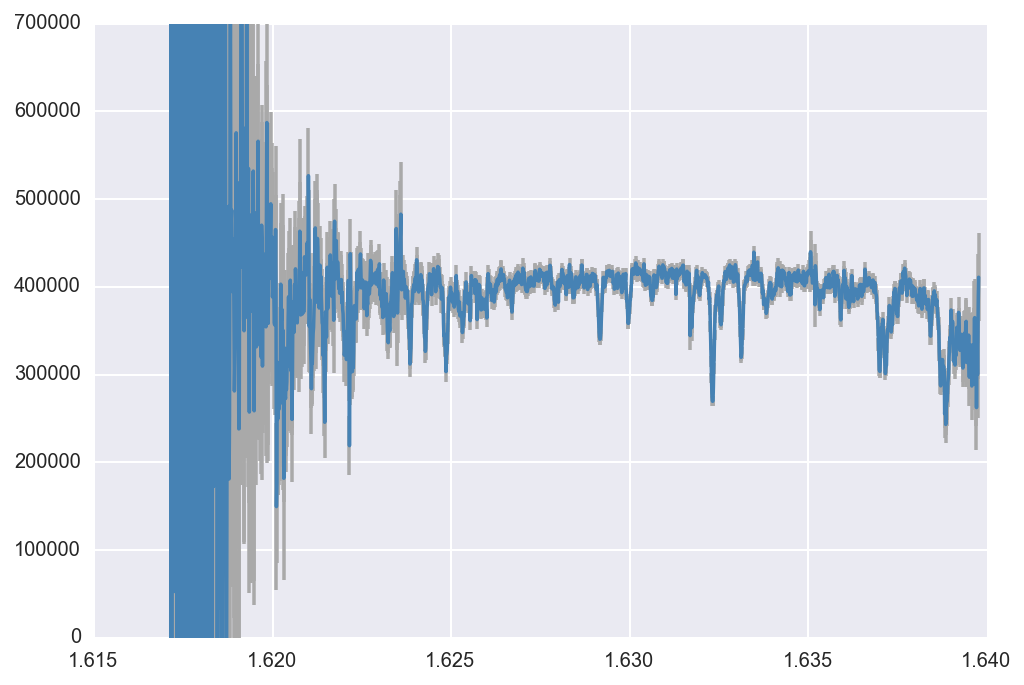

In [100]:
plt.errorbar(wavecut110,fluxcut110,yerr=sigcut110,color="steelblue",
             ecolor="darkgray")
plt.ylim(0,7e5)
plt.show()

### Trim really noisy section and convert $\mu$m to Angstroms.

In [107]:
gi110 = (wavecut110 > 1.623) & (wavecut110 < 1.640)

In [108]:
gi110.sum()

1559

In [109]:
wl_110 = wavecut110
fl_110 = fluxcut110
sg_110 = sigcut110

In [110]:
fls_out110 = fl_110[gi110]
sig_out110 = sg_110[gi110]
wls_out110 = wl_110[gi110]*10000.0
msk_out110 = np.ones(len(wls_out110), dtype=int)

### Scale the absolute values down to ~1.0 just for ease of plotting

In [111]:
med_fls110 = np.median(fls_out110)
fls_out110 = fls_out110 / med_fls110
sig_out110 = sig_out110 / med_fls110

<Container object of 3 artists>

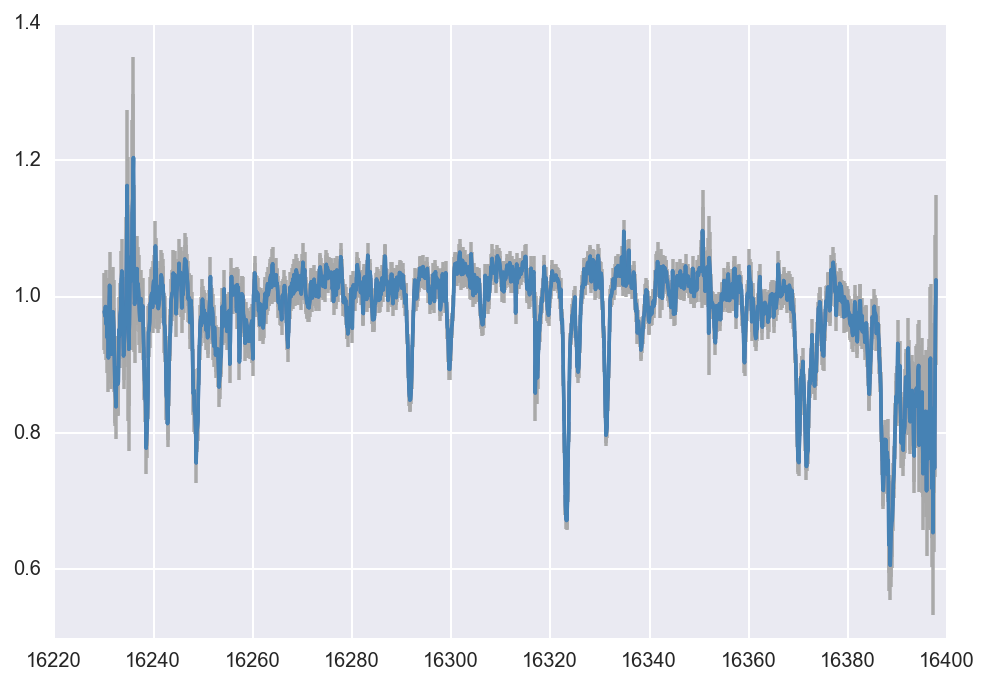

In [112]:
plt.plot(wls_out110, fls_out110)
plt.errorbar(wls_out110,fls_out110,yerr=sig_out110,color="steelblue",
             ecolor="darkgray")

In [113]:
import h5py

In [114]:
m = 110
out_name110 = '../data/reduced/subsub_m110.hdf5'.format(m)
f_new = h5py.File(out_name110, 'w')
f_new.create_dataset('fls', data=fls_out110)
f_new.create_dataset('wls', data=wls_out110)
f_new.create_dataset('sigmas', data=sig_out110)
f_new.create_dataset('masks', data=msk_out110)
print("{:.0f}  -  {:.0f}   {}".format(wls_out110[0], wls_out110[-1], out_name110))
f_new.close()

16230  -  16398   ../data/reduced/subsub_m110.hdf5


# Order 113

In [89]:
flux113 = dat.data[o113]
fluxcut113 = flux113[~np.isnan(flux113)]
wave113 = wav.data[o113]
wavecut113 = wave113[~np.isnan(flux113)]
sig113 = sig_scaled113
sigcut113 = sig113[~np.isnan(flux113)]

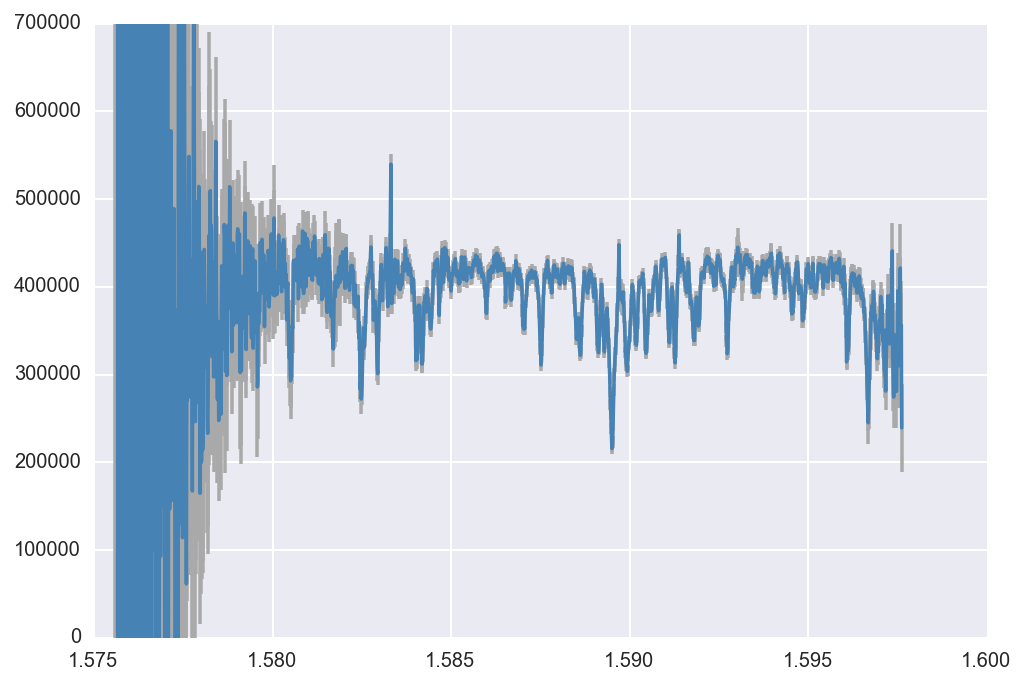

In [90]:
plt.errorbar(wavecut113,fluxcut113,yerr=sigcut113,color="steelblue",
             ecolor="darkgray")
plt.ylim(0,7e5)
plt.show()

In [91]:
! mkdir ../data/reduced

mkdir: ../data/reduced: File exists


### Trim really noisy section and convert $\mu$m to Angstroms.

In [92]:
gi113 = (wavecut113 > 1.580) & (wavecut113 < 1.597)

In [93]:
gi113.sum()

1607

In [94]:
wl_113 = wavecut113
fl_113 = fluxcut113
sg_113 = sigcut113

In [95]:
fls_out113 = fl_113[gi113]
sig_out113 = sg_113[gi113]
wls_out113 = wl_113[gi113]*10000.0
msk_out113 = np.ones(len(wls_out113), dtype=int)

### Scale the absolute values down to ~1.0 just for ease of plotting

In [96]:
med_fls113 = np.median(fls_out113)
fls_out113 = fls_out113 / med_fls113
sig_out113 = sig_out113 / med_fls113

<Container object of 3 artists>

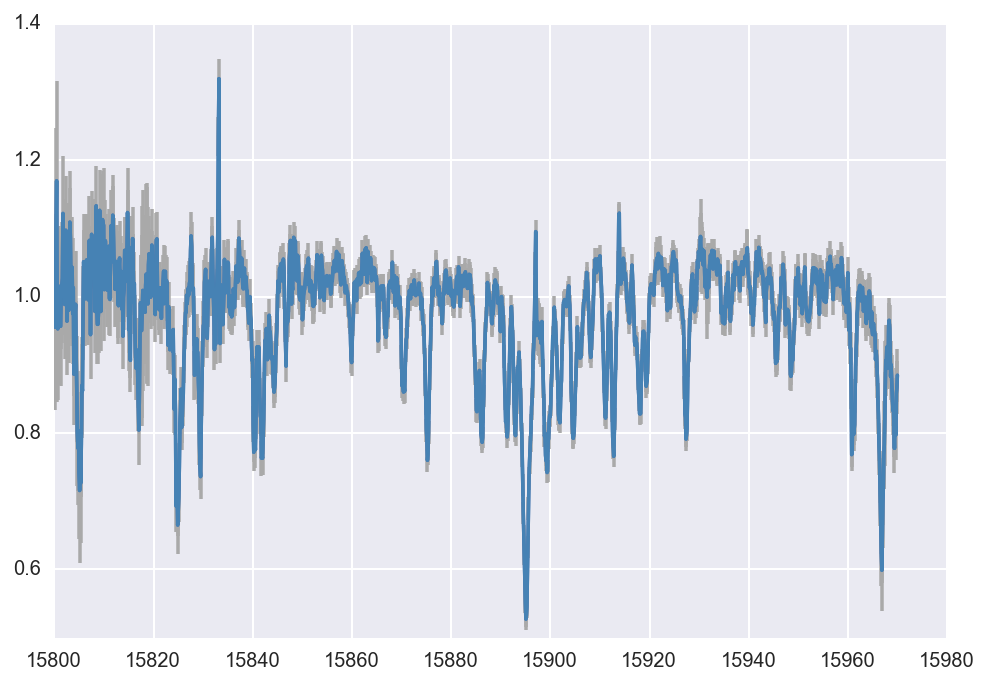

In [97]:
plt.plot(wls_out113, fls_out113)
plt.errorbar(wls_out113,fls_out113,yerr=sig_out113,color="steelblue",
             ecolor="darkgray")

In [98]:
m = 113
out_name113 = '../data/reduced/subsub_m113.hdf5'.format(m)
f_new = h5py.File(out_name113, 'w')
f_new.create_dataset('fls', data=fls_out113)
f_new.create_dataset('wls', data=wls_out113)
f_new.create_dataset('sigmas', data=sig_out113)
f_new.create_dataset('masks', data=msk_out113)
print("{:.0f}  -  {:.0f}   {}".format(wls_out113[0], wls_out113[-1], out_name113))
f_new.close()

15800  -  15970   ../data/reduced/subsub_m113.hdf5


# Order 115

In [28]:
flux115 = dat.data[o115]
fluxcut115 = flux115[~np.isnan(flux115)]
wave115 = wav.data[o115]
wavecut115 = wave115[~np.isnan(flux115)]
sig115 = sig_scaled115 # need to use the scaled sigma
sigcut115 = sig115[~np.isnan(flux115)]

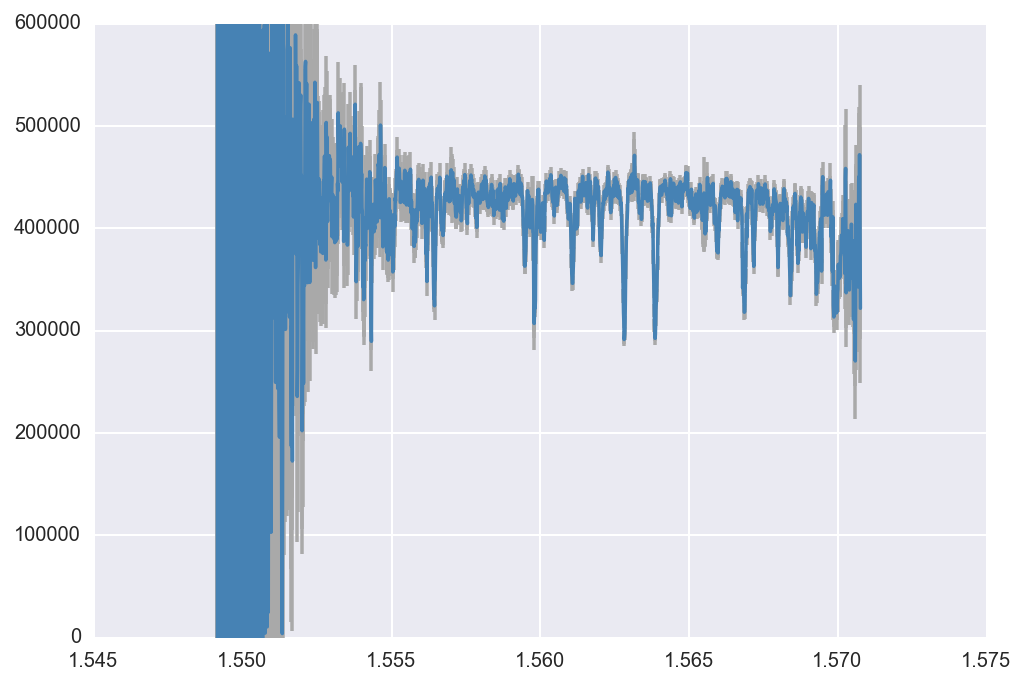

In [29]:
plt.errorbar(wavecut115,fluxcut115,yerr=sigcut115,color="steelblue",
             ecolor="darkgray")
plt.ylim(0,6e5)
plt.show()

### Trim NaNs

In [30]:
wavecut115.shape, fluxcut115.shape, sigcut115.shape

((2040,), (2040,), (2040,))

In [31]:
bi = (fluxcut115 != fluxcut115) | (sigcut115 != sigcut115)
len(bi), bi.sum()

(2040, 0)

Ok, so no more `NaN`s, that's good.

### Trim really noisy section and convert $\mu$m to Angstroms.

In [32]:
gi = (wavecut115 > 1.555) & (wavecut115 < 1.570)

In [33]:
gi.sum()

1455

In [34]:
wl = wavecut115
fl = fluxcut115
sg = sigcut115

In [35]:
fls_out = fl[gi]
sig_out = sg[gi]
wls_out = wl[gi]*10000.0
msk_out = np.ones(len(wls_out), dtype=int)

### Convert variance to sigma (if it's not already?)

This is done above.

### Scale the absolute values down to ~1.0 just for ease of plotting

In [85]:
med_fls = np.median(fls_out)
fls_out = fls_out / med_fls
sig_out = sig_out / med_fls

<Container object of 3 artists>

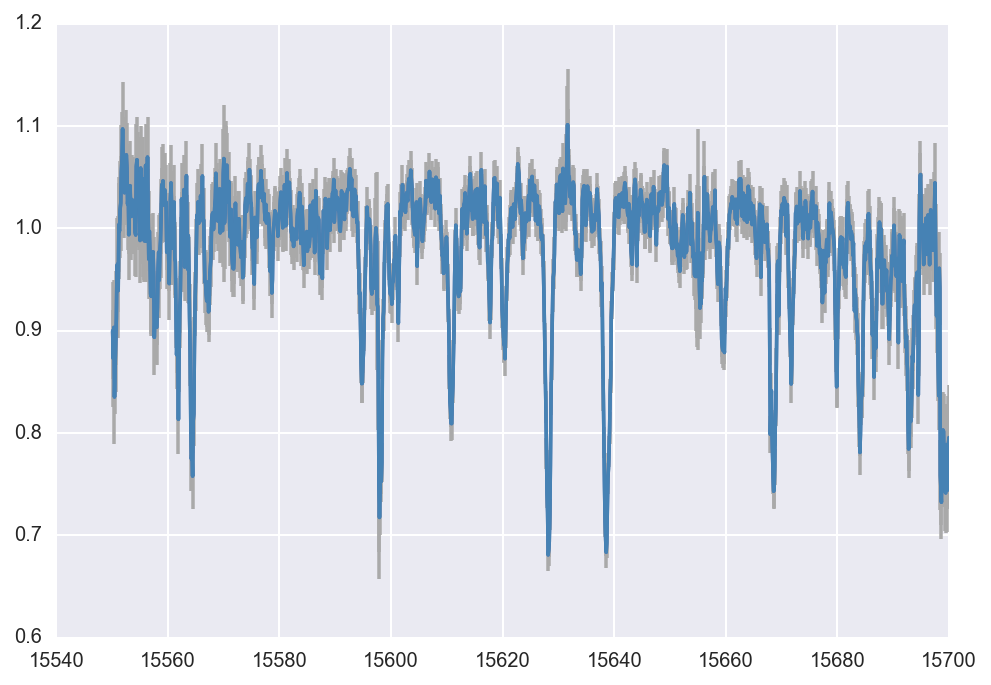

In [86]:
plt.plot(wls_out, fls_out)
plt.errorbar(wls_out,fls_out,yerr=sig_out,color="steelblue",
             ecolor="darkgray")

In [89]:
m = 115
out_name = '../data/reduced/subsub_m115.hdf5'.format(m)
f_new = h5py.File(out_name, 'w')
f_new.create_dataset('fls', data=fls_out)
f_new.create_dataset('wls', data=wls_out)
f_new.create_dataset('sigmas', data=sig_out)
f_new.create_dataset('masks', data=msk_out)
print("{:.0f}  -  {:.0f}   {}".format(wls_out[0], wls_out[-1], out_name))
f_new.close()

15550  -  15700   ../data/reduced/subsub_m115.hdf5


## ~~I only did m = 115.  Need to go back and clean the sigma vector for the other orders.~~   
## All the orders are cleaned and have HDF5 files in ../data/reduced/

The end for now.